# 1. Example Usage with Continuous Treatment Synthetic Data

## 1.1 DGP 
We use the data generating process (DGP) from [here](https://arxiv.org/abs/1806.03467). The DGP is described by the following equations:

\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

For this DGP, 
\begin{align}
\theta(x) = \exp(2\cdot x_1).
\end{align}

In [2]:
from _ortho_forest import DMLOrthoForest_test
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLasso
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [31]:
[min(i,2) for i in np.array([1,2,3])]

[1, 2, 2]

In [6]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [14]:
# DGP constants
np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
subsample_ratio = 0.3
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

In [15]:
TE

array([3.59718692, 3.18355349, 2.03398392, 1.71755779, 1.07058782,
       1.11802752, 4.60349483, 5.28158081, 5.33567993, 2.89020838,
       2.71836313, 3.75112803, 3.0994048 , 2.25126585, 1.81816953,
       7.1963129 , 6.52846146, 3.43147859, 2.12892758, 4.98275126,
       1.67385824, 2.16875854, 3.63625263, 1.90666445, 6.80729557,
       1.00879036, 3.6296722 , 5.64277055, 3.21247786, 1.51300497,
       1.06475057, 1.94458508, 2.01713142, 1.14911336, 4.56928623,
       3.50348054, 1.19536593, 1.54026417, 2.28555515, 1.76313377,
       2.02093646, 1.33029786, 1.99004405, 2.71855686, 1.91139002,
       2.4469948 , 1.94371211, 1.18818658, 2.97523941, 3.62349661,
       1.66937816, 4.36802049, 4.81852683, 5.7917611 , 1.83761259,
       3.43895981, 3.21538828, 1.9761026 , 2.17484345, 1.43978463,
       2.71564059, 4.23441223, 6.89312351, 1.42015512, 5.22019251,
       6.54342043, 5.62326516, 1.36465236, 5.77724512, 1.58152686,
       1.41613515, 6.02076447, 1.95370243, 4.2960954 , 1.36274

In [12]:
TE = np.column_stack((np.array([exp_te(x_i) for x_i in X]), np.array([exp_te(2*x_i) for x_i in X])))

In [13]:
TE

array([[ 3.59718692, 12.93975376],
       [ 3.18355349, 10.13501281],
       [ 2.03398392,  4.13709061],
       ...,
       [ 1.85432367,  3.43851629],
       [ 2.91041151,  8.47049517],
       [ 2.99386191,  8.96320913]])

## 1.2. Train Estimator

**Note:** The models in the final stage of the estimation (``model_T_final``, ``model_Y_final``) need to support sample weighting. 

If the models of choice do not support sample weights (e.g. ``sklearn.linear_model.LassoCV``), the ``econml`` packages provides a convenient wrapper for these models ``WeightedModelWrapper`` in order to allow sample weights.

In [4]:
est = DMLOrthoForest_test(
    n_trees=1000, min_leaf_size=5,
    max_depth=50,
    subsample_ratio=subsample_ratio,
    model_T=Lasso(alpha=lambda_reg),
    model_Y=Lasso(alpha=lambda_reg),
    model_T_final=WeightedLasso(alpha=lambda_reg),
    model_Y_final=WeightedLasso(alpha=lambda_reg),
    global_residualization=False,
    random_state=123
    )

To use the built-in confidence intervals constructed via Bootstrap of Little Bags, we can specify `inference="blb"` at `fit` time or leave the default `inference='auto'` which will automatically use the Bootstrap of Little Bags.

In [6]:
est.fit(Y, T, X=X, W=W, inference="blb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


KeyboardInterrupt: 

In [82]:
# Calculate treatment effects
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   16.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished


In [83]:
# Calculate default (95%) confidence intervals for the test data
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


In [84]:
res = est.effect_inference(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


In [85]:
res.summary_frame().head()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.148,0.169,6.776,0.0,0.816,1.480
1,1.159,0.161,7.193,0.0,0.843,1.475
2,1.170,0.153,7.637,0.0,0.870,1.470
3,1.181,0.146,8.108,0.0,0.895,1.466
4,1.192,0.139,8.601,0.0,0.920,1.464


In [86]:
res.population_summary()

Similarly we can estimate effects and get confidence intervals and inference results using a `CausalForest`.

In [51]:
est2 = CausalForestDML(model_t=Lasso(alpha=lambda_reg),
                       model_y=Lasso(alpha=lambda_reg),
                       n_estimators=4000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test, alpha=0.01)

## 1.3. Performance Visualization

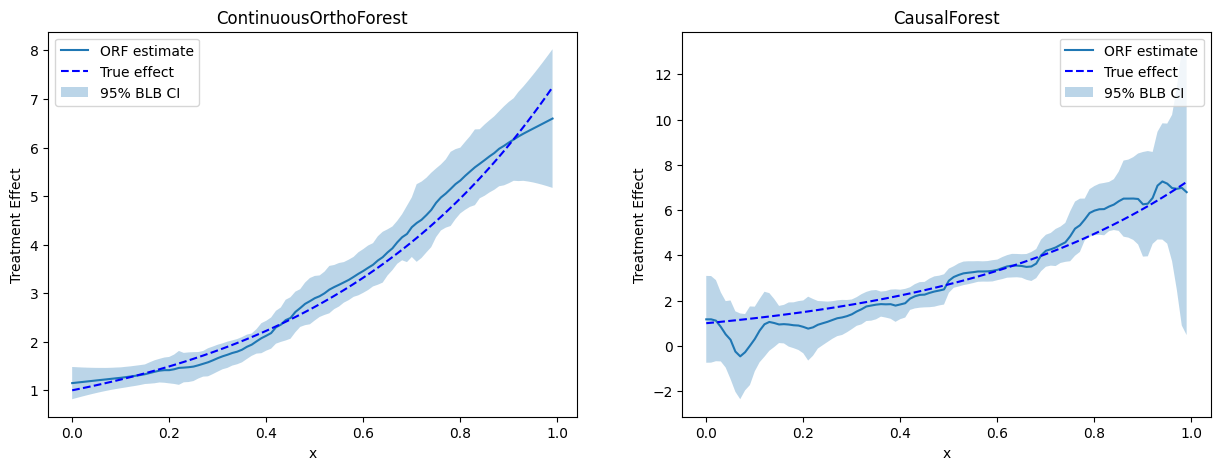

In [87]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("ContinuousOrthoForest")
plt.plot(X_test, treatment_effects, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("CausalForest")
plt.plot(X_test, treatment_effects2, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()